In [1]:
%matplotlib inline
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
import xarray as xr

In [2]:
def plot(year=1999, month=6, day=19, hour=12, varname='airtemp', level=850, save=False):
    
    dt = datetime(year, month, 1)

    # Grab Pressure Level Data
    hght_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/hgt.{dt:%Y%m}.nc')
    air_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                               f'NARR/pressure/air.{dt:%Y%m}.nc')
    shum_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/shum.{dt:%Y%m}.nc')
    uwnd_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/uwnd.{dt:%Y%m}.nc')
    vwnd_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/vwnd.{dt:%Y%m}.nc')

    # Pull out the lat and lon data
    lat = hght_data.lat.values
    lon = hght_data.lon.values

    plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                    standard_parallels=[30, 60])

    datacrs = ccrs.PlateCarree()

    tlatslons = plotcrs.transform_points(datacrs, lon, lat)
    tlon = tlatslons[:,:,0]
    tlat = tlatslons[:,:,1]

    dt = datetime(year, month, day ,hour)
    vtimes = hght_data.time.sel(time=dt).values.astype('datetime64[ms]').astype('O')

    hght = mpcalc.smooth_n_point(hght_data.hgt.sel(time=dt, level=level), 9, 10)
    uwnd = mpcalc.smooth_n_point(uwnd_data.uwnd.sel(time=dt, level=level), 9, 10)
    vwnd = mpcalc.smooth_n_point(vwnd_data.vwnd.sel(time=dt, level=level), 9, 10)
    
    if varname=='wind_speed':
        variable = mpcalc.wind_speed(uwnd, vwnd)
    elif varname=='relhum':
        shum = mpcalc.smooth_n_point(shum_data.shum.sel(time=dt, level=level), 9, 10)
        tmpk = mpcalc.smooth_n_point(air_data.air.sel(time=dt, level=level), 9, 10)
        e = mpcalc.vapor_pressure(level * units('hPa'), shum)
        es = mpcalc.saturation_vapor_pressure(tmpk)
        rel_hum = e / es * 100
    elif (varname=='vort') | (varname=='absvort'):
        dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
        if varname=='vort':
            variable = mpcalc.vorticity(uwnd, vwnd, dx, dy)*1e5
        elif varname=='absvort':
            variable =  mpcalc.absolute_vorticity(uwnd, vwnd, dx, dy, lat*units('degree'))*1e5
    elif varname=='airtemp':
        variable = mpcalc.smooth_n_point(air_data.air.sel(time=dt, level=level), 9, 10)
    
    fig = plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(111, projection=plotcrs)
    ax.set_extent([230., 290., 20., 55.], ccrs.PlateCarree())

    # Add state boundaries to plot
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    # Add country borders to plot
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    
    # Add coastlines to plot
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

    if level > 925:
        cint = range(0, 5000, 10)
    elif (level <= 925) & (level > 600):
        cint = range(0, 5000, 30)
    elif (level <= 600) & (level > 400):
        cint = range(0, 10000, 60)
    else:
        cint = range(0, 20000, 120)
        
    # Contour based on variable chosen
    cs = ax.contour(tlon, tlat, hght, cint, linewidths=2, colors='black')
    plt.clabel(cs, inline=True, fmt='%d')
        
    if varname == 'airtemp':
        variable = variable.to('degC')
        cf = ax.contourf(tlon, tlat, variable, range(-50, 51, 2), cmap=plt.cm.coolwarm, extend='both')
        cs = ax.contour(tlon, tlat, variable, range(-50, 51, 2), colors='darkgrey',
                        linestyles='dotted', extend='both')
        plt.clabel(cs, fmt='%d')
        plt.title(f'{level}-hPa Heights (m), Temp (C), and Wind Barbs (kts)', loc='left')
    elif varname=='wind_speed':
        if level<=500:
            fint = range(50,211,20)
        else:
            fint = range(10,100,20)
        cf = ax.contourf(tlon, tlat, variable.to('kts'), fint, cmap=plt.cm.BuPu, extend='both')
        plt.title(f'{level}-hPa Heights (m), Wind Speed (kts), and Wind Barbs (kts)', loc='left')
    elif varname=='relhum':
        cf = ax.contourf(tlon, tlat, rel_hum, range(50,100,5), cmap=plt.cm.Greens, extend='max')
        plt.title(f'{level}-hPa Heights (m), Relative Humidity (%), and Wind Barbs (kts)', loc='left')
    elif (varname=='vort'):
        fint = range(-15,16)
        fline = 'PuOr_r'
        cf = ax.contourf(tlon, tlat, variable, fint, cmap=fline, extend='both')
        plt.title(f'{level}-hPa Heights (m), Vorticity ($1e5$ $s^{-1}$), and Wind Barbs (kts)', loc='left')
    elif varname=='absvort':
        clevavor500 = list(range(-8, 1, 1))+list(range(8, 49, 2))
        colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 31))
        colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
        colorsavor500 = np.vstack((colors2, (1, 1, 1, 1), colors1))
        cf = ax.contourf(tlon, tlat, variable, clevavor500, colors=colorsavor500, extend='both')
        plt.title(f'{level}-hPa Heights (m), Abs. Vorticity ($1e5$ $s^{-1}$), and Wind Barbs (kts)', loc='left')
    
    cb = fig.colorbar(cf, orientation='horizontal', ax=ax, pad=0, aspect=50, extendrect='True')

    if varname == 'airtemp':
        cb.set_label(r'$^{o}C$', size='large')
        
    # Plot Wind Barbs
    # Transform Vectors and plot wind barbs.
    wind_slice = [slice(None, None, 6), slice(None, None, 6)]
    ax.barbs(lon[wind_slice], lat[wind_slice],
             uwnd[wind_slice].to('kts').m, vwnd[wind_slice].to('kts').m,
             length=6, pivot='middle',transform=ccrs.PlateCarree())

    
    plt.title(f'VALID: {vtimes}', loc='right')
    
    if save:
        plt.savefig(f'NARR_{varname}_{dt:%Y%m%d}_{dt:%H%M}.png', dpi=150, bbox_inches='tight')
    plt.show()



In [3]:
year_widget = widgets.Dropdown(
    options=list(range(1979,2019)),
    description='Year', alignment='center')

month_widget = widgets.Dropdown(
    options=list(range(1,13)),
    description='Month', alignment='center')

var_widget = widgets.Dropdown(
    options={'Temperature': 'airtemp',
             'Relative Humidity': 'relhum',
             'Wind Speed': 'wind_speed',
             'Vorticity': 'vort',
             'Absolute Vorticity': 'absvort'},
    description='Variable', alignment='center')

day_widget = widgets.Dropdown(description='Day', options=list(range(1,32)))

hour_widget = widgets.Dropdown(description='Hour', options=[0,3,6,9,12,15,18,21])

level_widget = widgets.Dropdown(description='Level', options=[1000,925,850,700,500,300,250,200,100])



In [4]:
p = widgets.interact_manual(plot, varname=var_widget, level=level_widget, year=year_widget, month=month_widget, day=day_widget, hour=hour_widget)

interactive(children=(Dropdown(description='Year', options=(1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 19…

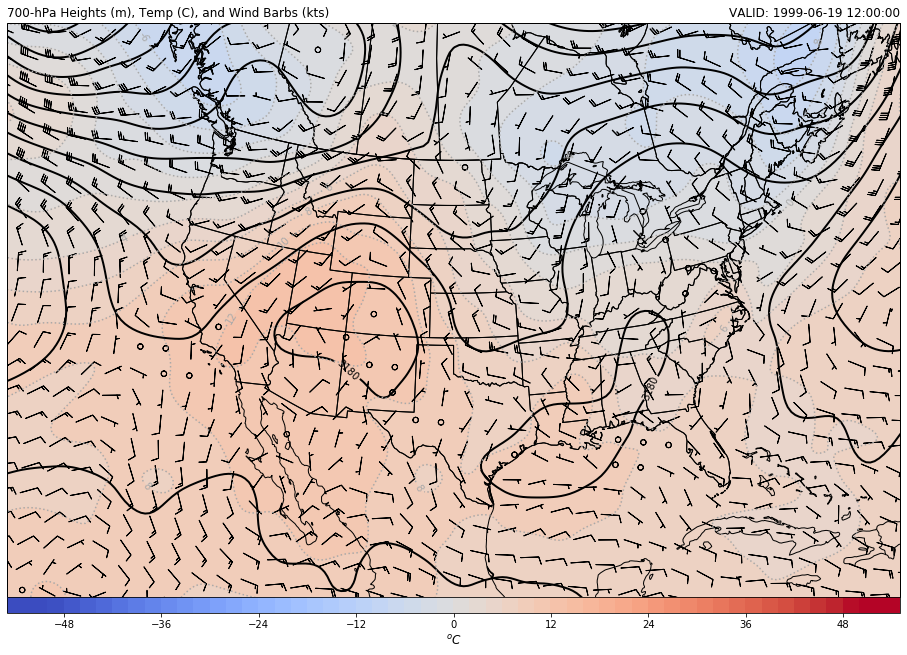

In [5]:
plot(level=700)